In [4]:
#IMPORTING ALL THE LIBRARIES

import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from zipfile import ZipFile

from keras.preprocessing.image import img_to_array
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')

In [5]:
!pip install rembg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.2 MB/s eta 0:00:00


In [6]:
# Image Preprocessing Functions
from rembg import remove
from PIL import Image, ImageChops

def preproc_img(im):
  #STEP 1: Dealing with shitty background
  bg_removed = remove(im)
  def trim(im):
    im = Image.fromarray(im)
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

  cropped = trim(bg_removed)

  #Step 2: Bringing to desired dimensions
  cropped.thumbnail((128, 128))
  width, height = cropped.size
  final = Image.new(cropped.mode, (128, 128), (255,255,255))
  final.paste(cropped, ((128-width)//2, (128-height)//2))
  return final

In [7]:
#Extracting Zipped Files
with ZipFile("Chess_Images.zip", 'r') as zipped:
  zipped.extractall(path="Unzipped")

In [10]:
os.mkdir('PreProcessed_Images_Random')

In [11]:
#Extracting, PreProcessing and saving Images

import os
path = 'Unzipped/Chessman-image-dataset/Chess/'
classes = ['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']

X = []

nam = 0
for i in classes:
  #Reducing number of images for reducing training time
  im_num = 0
  for img_name in os.listdir(path+i):
    img_data=[]
    img = cv.imread(path+i+'/'+img_name)
    if img is not None:
      rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
      rgb_img = preproc_img(rgb_img)

      background = Image.new("RGB", rgb_img.size, (255, 255, 255))
      background.paste(rgb_img, mask=rgb_img.split()[3])

      background.save(f"PreProcessed_Images_Random/{nam}.png")

      img_arr = np.array(background)
      X.append(img_arr)
      nam+=1
    im_num+=1
    if (im_num==20):
      break

  print(f"Done {i}")

Done Bishop
Done King
Done Knight
Done Pawn
Done Queen
Done Rook


In [12]:
#Reshaping and normalizing
X_final=np.reshape(X, (len(X),128, 128, 3))
X_final=X_final.astype('float32')/255

In [19]:
!zip -r /content/PreProcessed_Images_Random.zip /content/PreProcessed_Images_Random

  adding: content/PreProcessed_Images_Random/ (stored 0%)
  adding: content/PreProcessed_Images_Random/115.png (stored 0%)
  adding: content/PreProcessed_Images_Random/15.png (deflated 0%)
  adding: content/PreProcessed_Images_Random/74.png (deflated 0%)
  adding: content/PreProcessed_Images_Random/111.png (stored 0%)
  adding: content/PreProcessed_Images_Random/107.png (stored 0%)
  adding: content/PreProcessed_Images_Random/51.png (stored 0%)
  adding: content/PreProcessed_Images_Random/102.png (stored 0%)
  adding: content/PreProcessed_Images_Random/38.png (stored 0%)
  adding: content/PreProcessed_Images_Random/92.png (stored 0%)
  adding: content/PreProcessed_Images_Random/97.png (deflated 0%)
  adding: content/PreProcessed_Images_Random/81.png (deflated 0%)
  adding: content/PreProcessed_Images_Random/67.png (stored 0%)
  adding: content/PreProcessed_Images_Random/108.png (deflated 0%)
  adding: content/PreProcessed_Images_Random/52.png (stored 0%)
  adding: content/PreProcessed_

In [20]:
#Downloading preprocessed images
from google.colab import files
files.download("PreProcessed_Images_Random.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
#Test-Train Split
X_train, X_test = X_final[:100], X_final[100:]

In [22]:
#Encoder Construction

model=Sequential()

#Encoder Part
model.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(128,128,3)))
model.add(MaxPooling2D((2,2), padding='same'))
model.add(Conv2D(32, (3,3),activation='relu',padding='same'))
model.add(MaxPooling2D((2,2), padding='same'))
model.add(Conv2D(16, (3,3),activation='relu',padding='same'))
model.add(MaxPooling2D((2,2), padding='same'))

#Decoder Part
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(3, (3,3), activation='relu', padding='same'))

#Model Compilation
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 16)        0

In [24]:
#Training the model
#Redoced the number of epochs from 500 to 100 for reducing training time
model.fit(X_final, X_final, epochs=100, shuffle=True)

Epoch 1/100
4/4 [==============================] - 14s 3s/step - loss: 0.4180 - accuracy: 0.2331
Epoch 2/100
4/4 [==============================] - 11s 3s/step - loss: 0.1149 - accuracy: 0.6040
Epoch 3/100
4/4 [==============================] - 11s 3s/step - loss: 0.0943 - accuracy: 0.8918
Epoch 4/100
4/4 [==============================] - 11s 3s/step - loss: 0.0638 - accuracy: 0.6160
Epoch 5/100
4/4 [==============================] - 11s 3s/step - loss: 0.0571 - accuracy: 0.0408
Epoch 6/100
4/4 [==============================] - 11s 3s/step - loss: 0.0432 - accuracy: 0.0411
Epoch 7/100
4/4 [==============================] - 11s 3s/step - loss: 0.0340 - accuracy: 0.5485
Epoch 8/100
4/4 [==============================] - 11s 3s/step - loss: 0.0306 - accuracy: 0.8151
Epoch 9/100
4/4 [==============================] - 11s 3s/step - loss: 0.0264 - accuracy: 0.7676
Epoch 10/100
4/4 [==============================] - 11s 3s/step - loss: 0.0242 - accuracy: 0.2148
Epoch 11/100
4/4 [===========

In [25]:
os.mkdir('Reconstructed_Train_Images')
os.mkdir('Reconstructed_Test_Images')

4/4 [==============================] - 4s 690ms/step


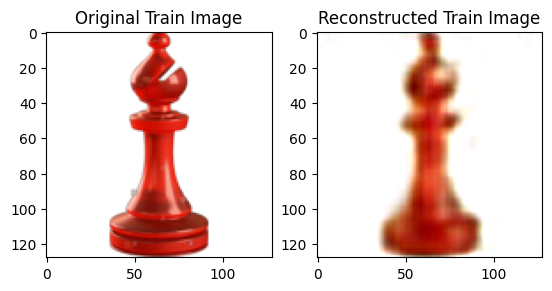

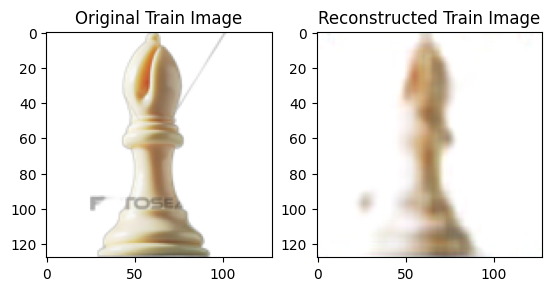

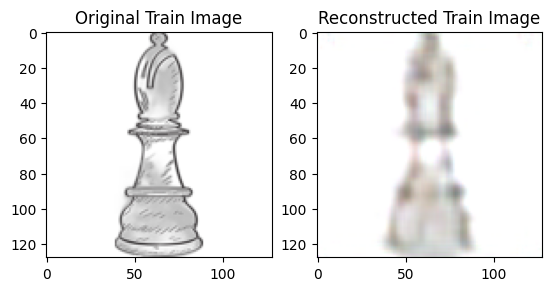

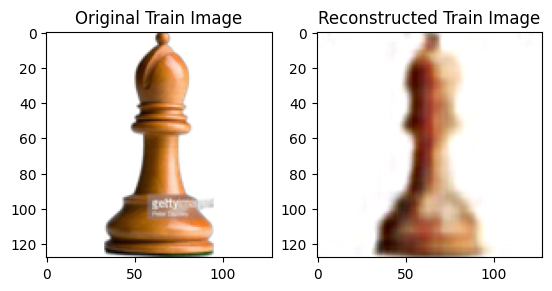

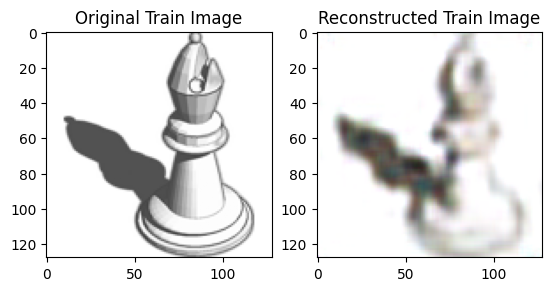

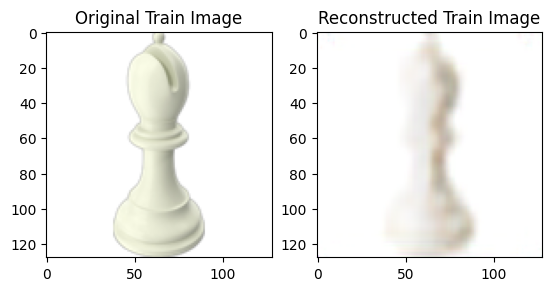

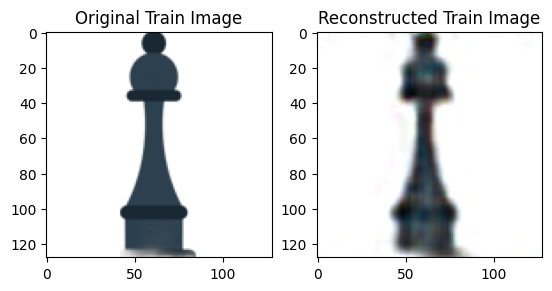

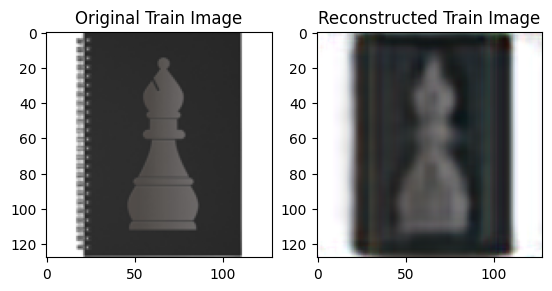

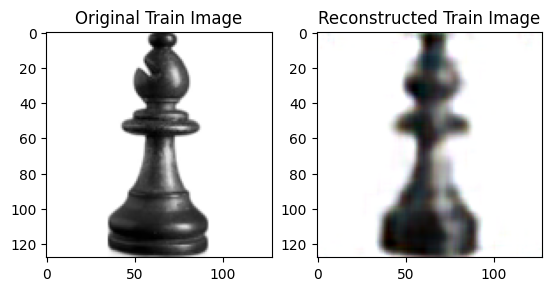

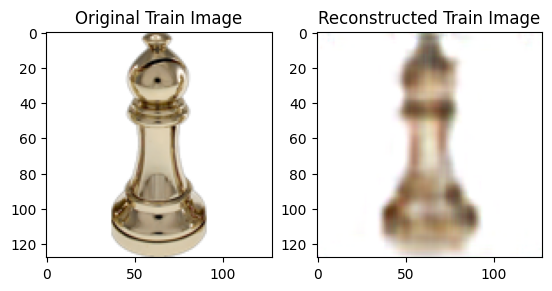

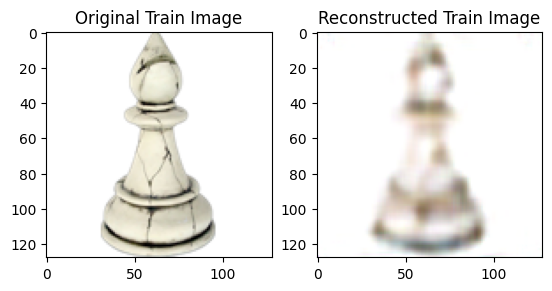

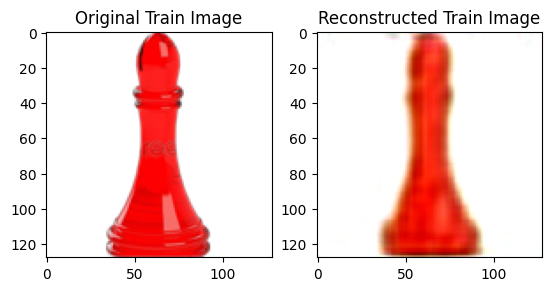

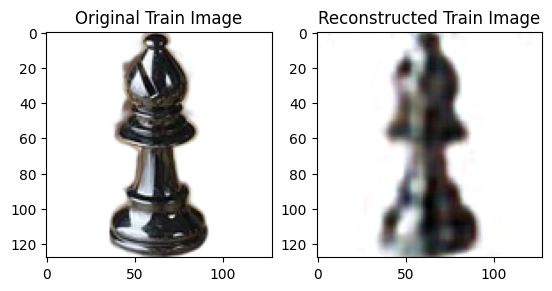

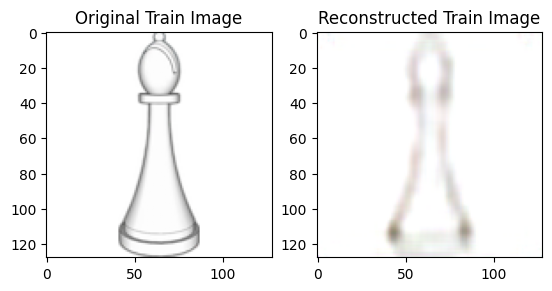

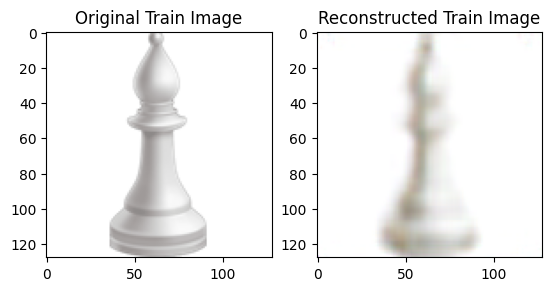

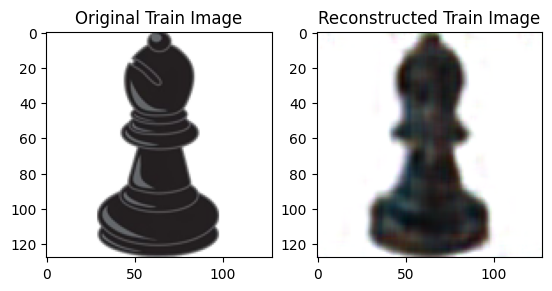

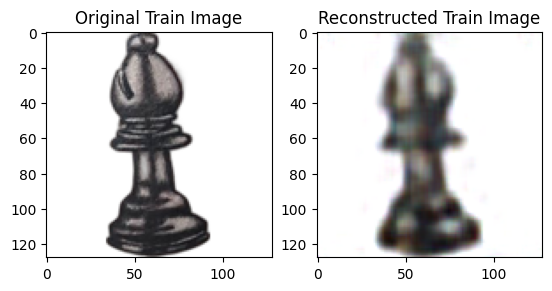

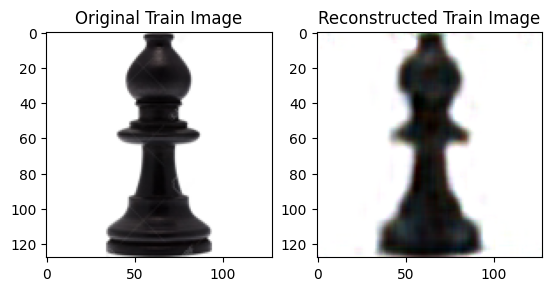

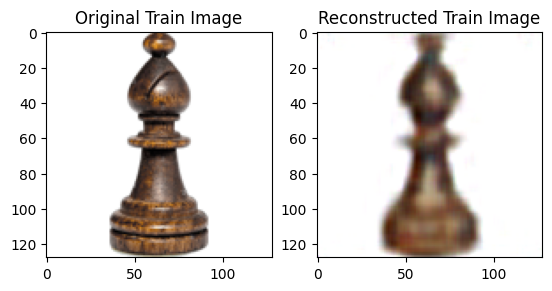

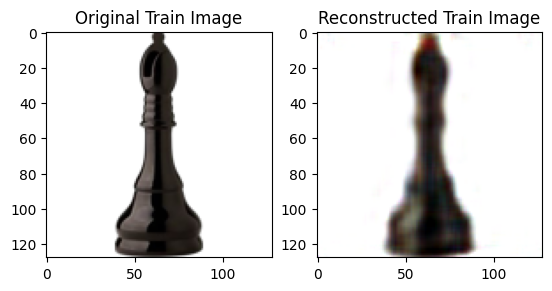

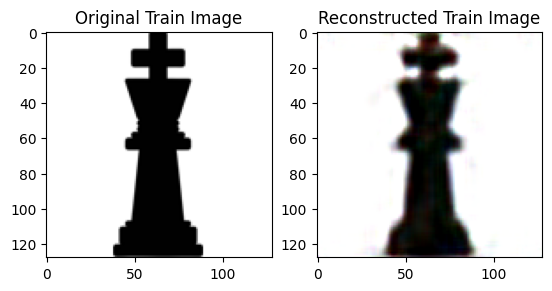

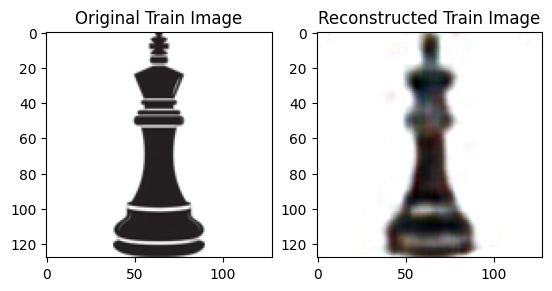

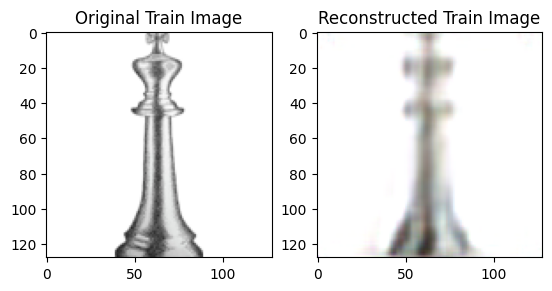

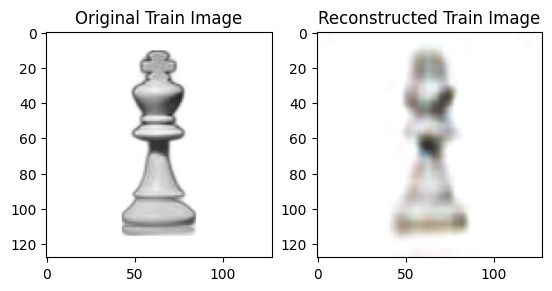

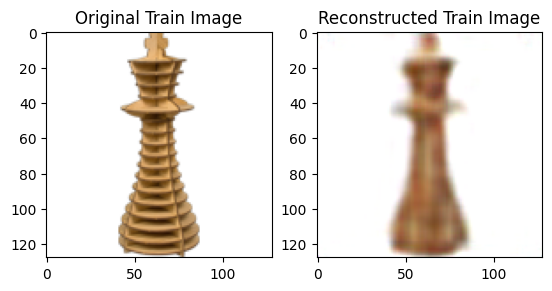

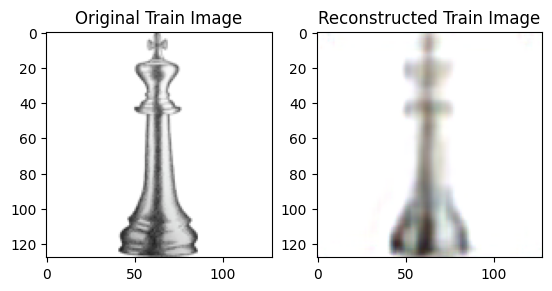

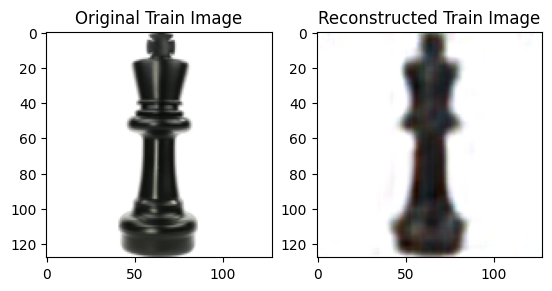

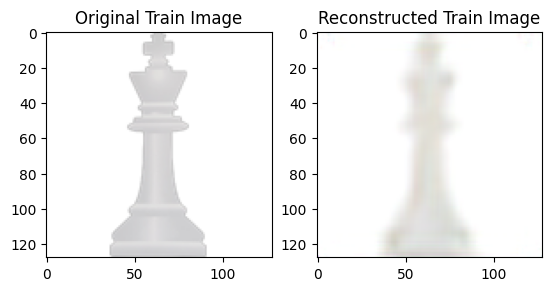

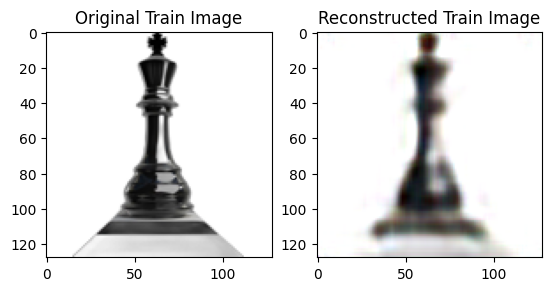

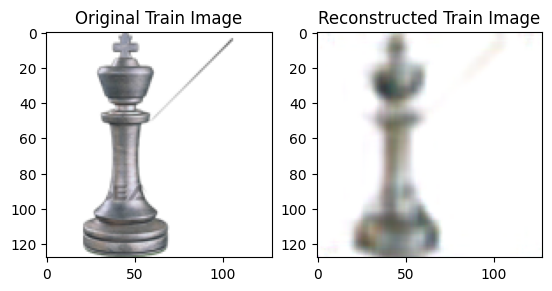

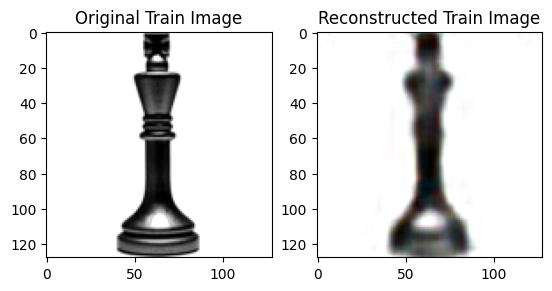

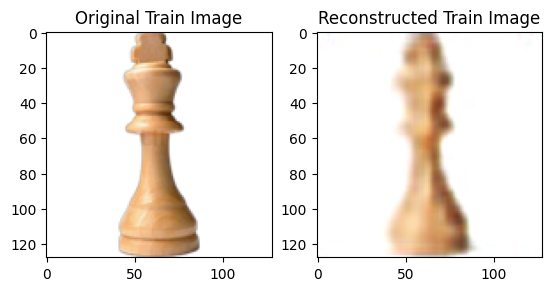

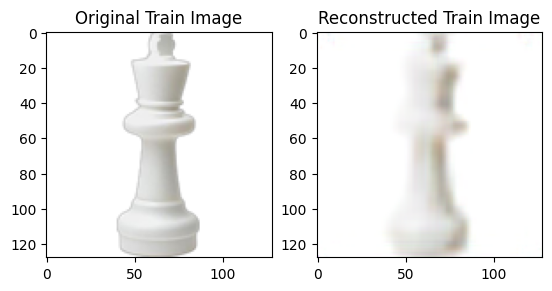

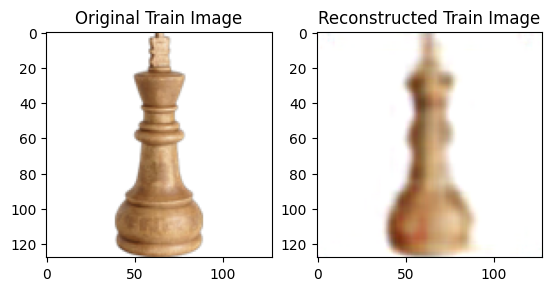

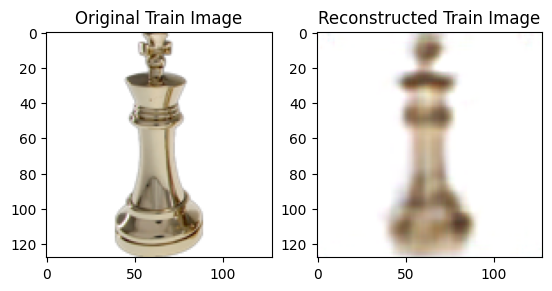

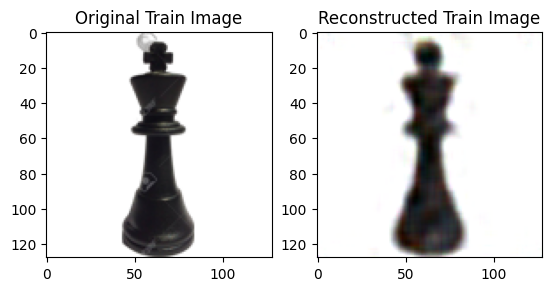

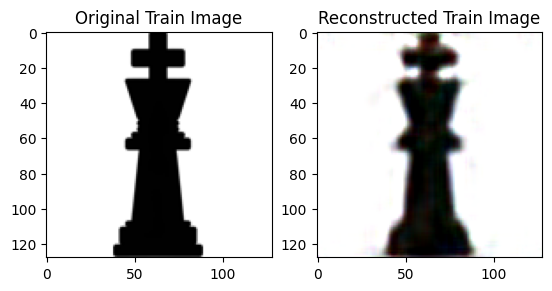

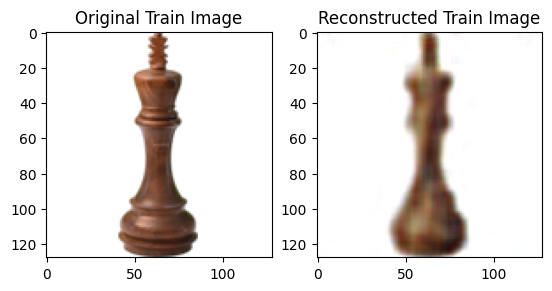

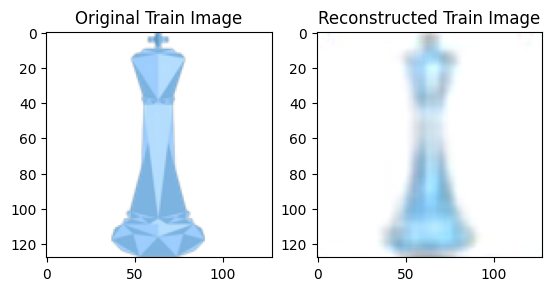

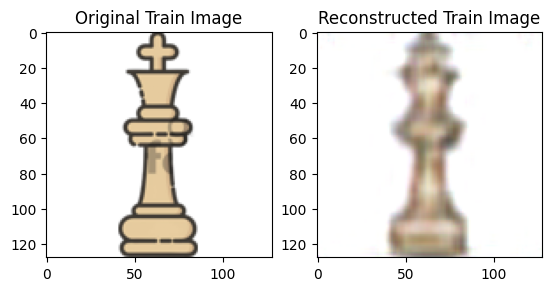

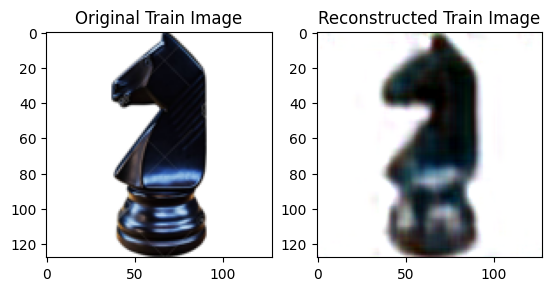

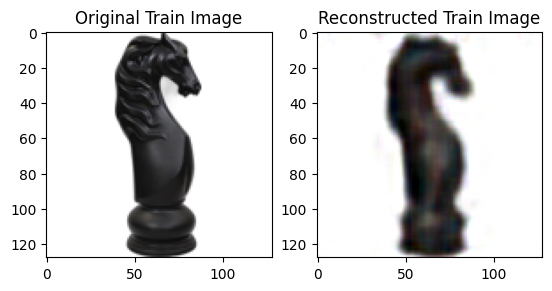

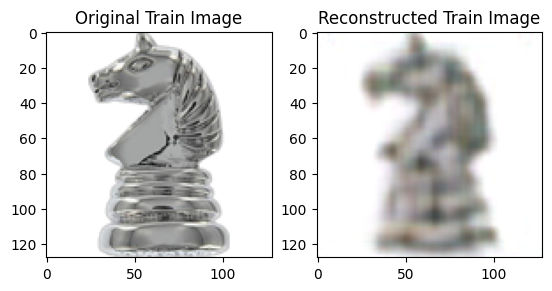

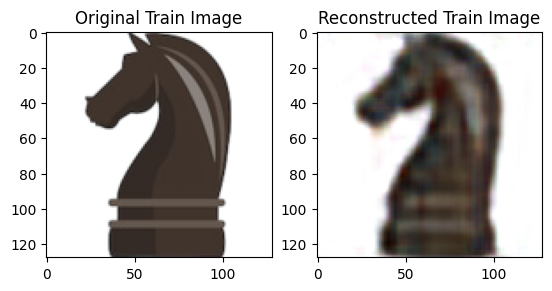

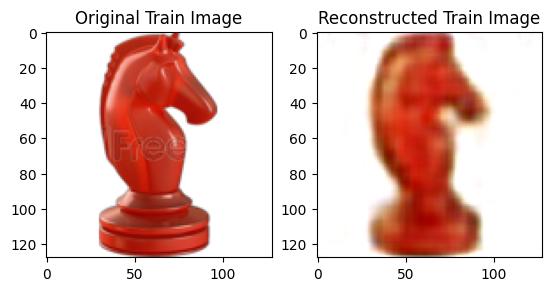

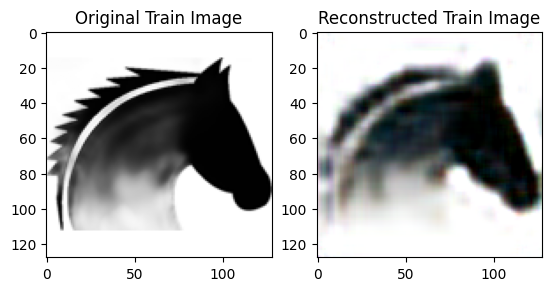

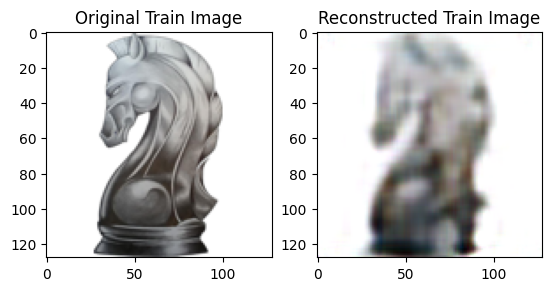

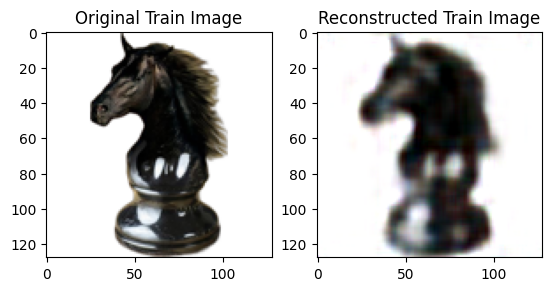

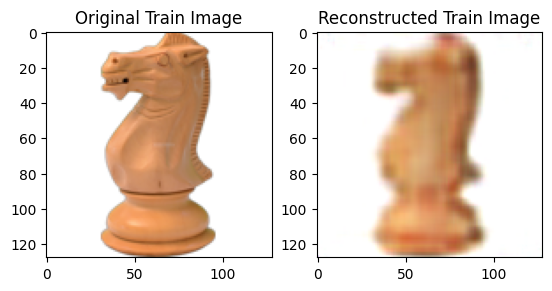

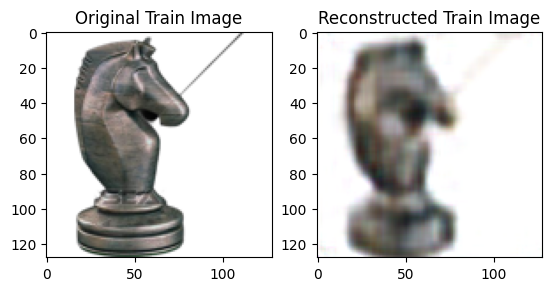

In [30]:
#RECONSTRUCTION OF TRAIN DATA
pred_train=model.predict(X_train)
for i in range(len(X_train)):
  if i<50:
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(X_train[i])
    ax[1].imshow(pred_train[i].reshape(128,128,3))
    ax[0].set_title("Original Train Image")
    ax[1].set_title("Reconstructed Train Image")
    plt.show()
  im_sv = Image.fromarray(pred_train[i].reshape(128,128,3), "RGB")
  im_sv.save(f"Reconstructed_Train_Images/{i}.jpeg")

1/1 [==============================] - 1s 745ms/step


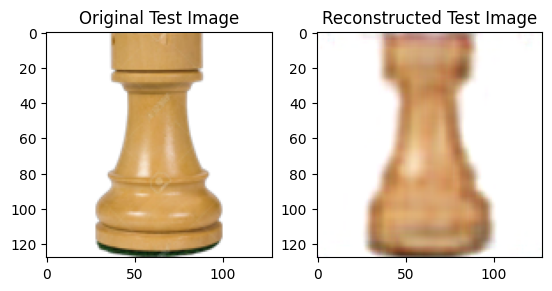

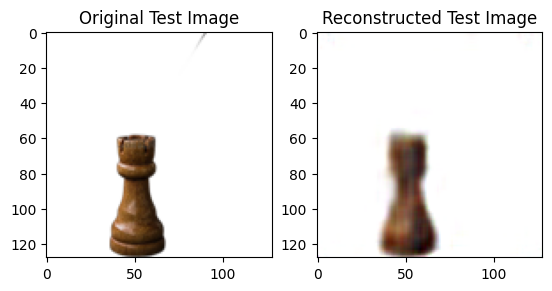

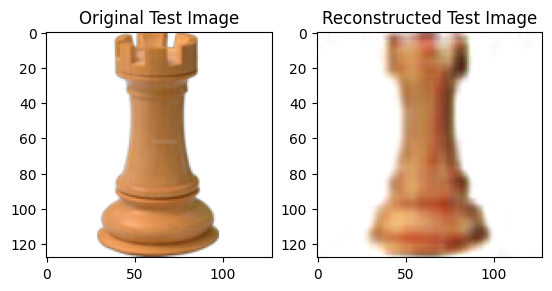

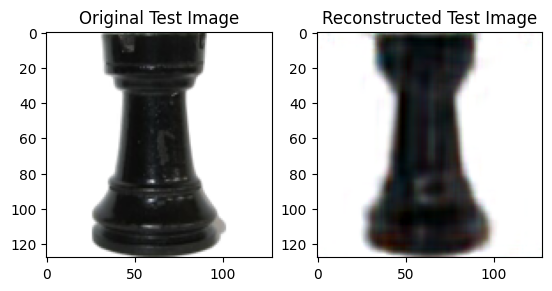

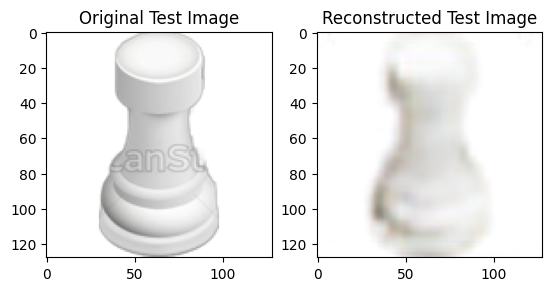

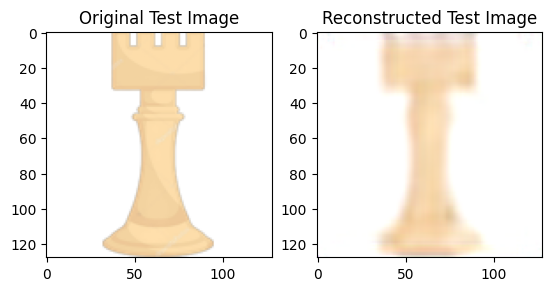

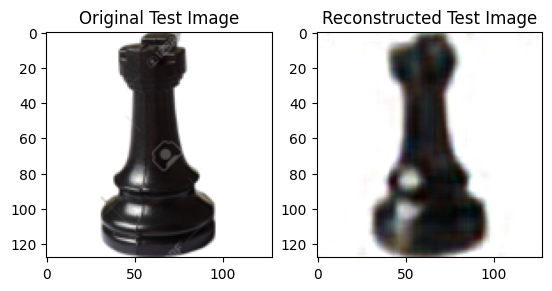

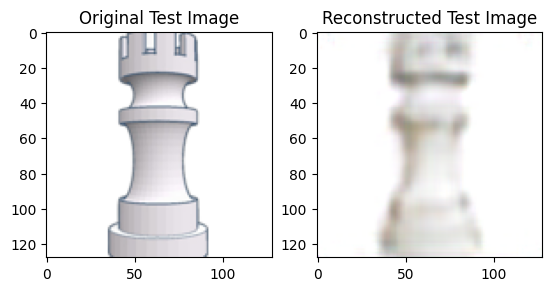

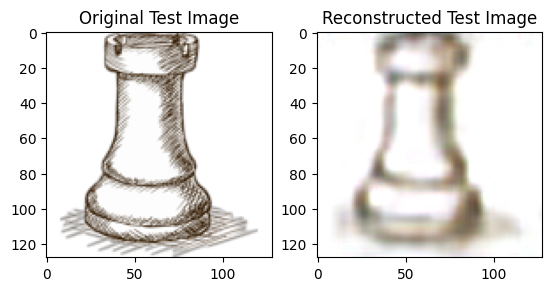

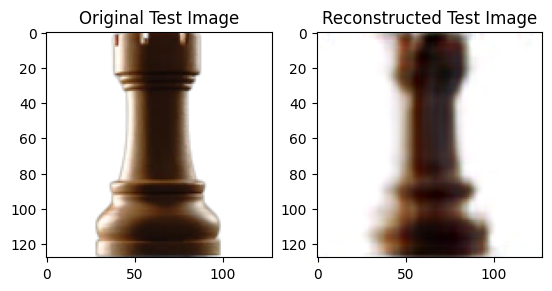

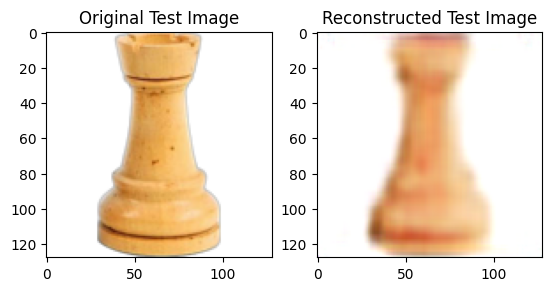

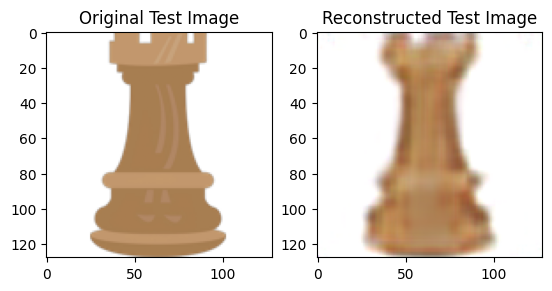

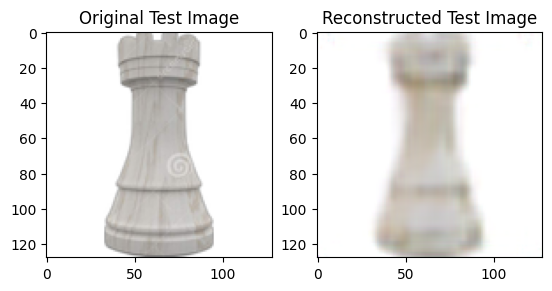

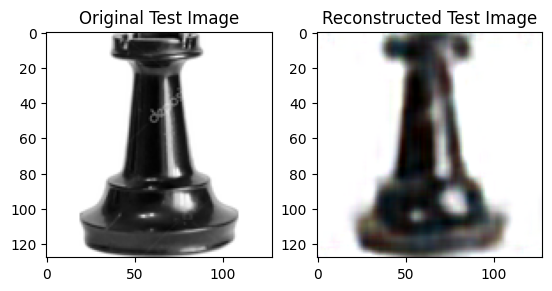

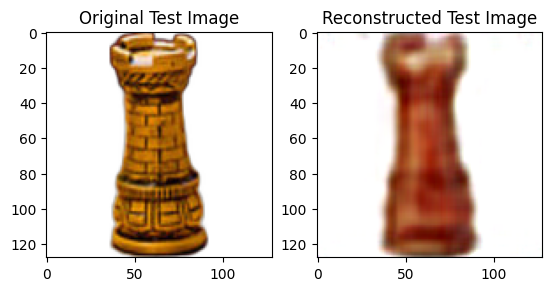

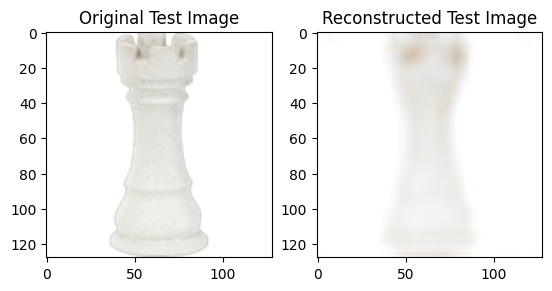

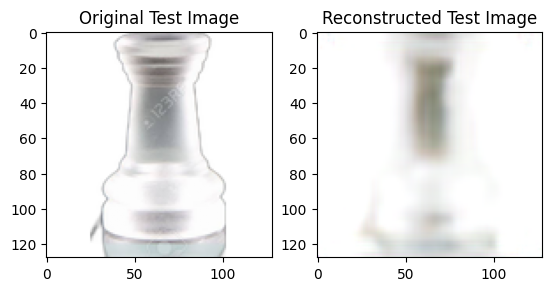

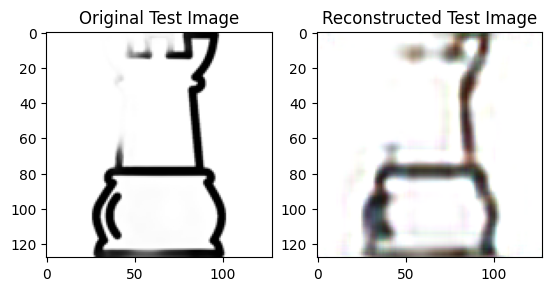

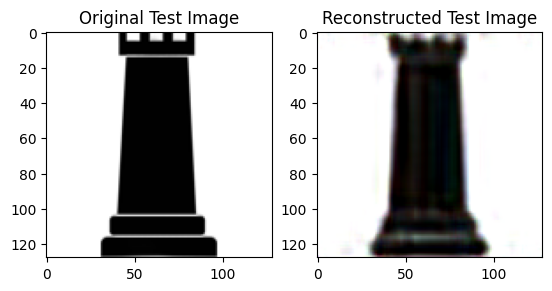

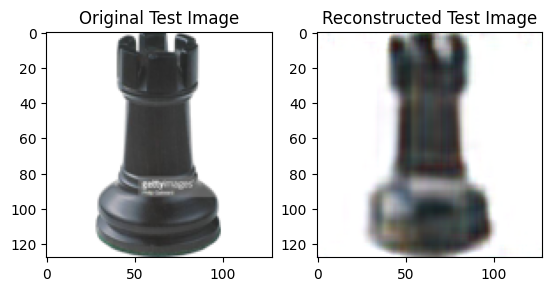

In [32]:
#RECONSTRUCTION OF TEST DATA
pred_test=model.predict(X_test)
for i in range(len(X_test)):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(X_test[i])
    ax[1].imshow(pred_test[i].reshape(128,128,3))
    ax[0].set_title("Original Test Image")
    ax[1].set_title("Reconstructed Test Image")
    plt.show()
    im_sv = Image.fromarray(pred_test[i].reshape(128,128,3), "RGB")
    im_sv.save(f"Reconstructed_Test_Images/Test_{i}.jpeg")

In [33]:
!zip -r /content/Reconstructed_Test_Images.zip /content/Reconstructed_Test_Images

  adding: content/Reconstructed_Test_Images/ (stored 0%)
  adding: content/Reconstructed_Test_Images/Test_9.jpeg (deflated 2%)
  adding: content/Reconstructed_Test_Images/Test_8.jpeg (deflated 2%)
  adding: content/Reconstructed_Test_Images/Test_15.jpeg (deflated 2%)
  adding: content/Reconstructed_Test_Images/Test_11.jpeg (deflated 2%)
  adding: content/Reconstructed_Test_Images/Test_4.jpeg (deflated 2%)
  adding: content/Reconstructed_Test_Images/Test_7.jpeg (deflated 2%)
  adding: content/Reconstructed_Test_Images/Test_3.jpeg (deflated 2%)
  adding: content/Reconstructed_Test_Images/Test_6.jpeg (deflated 2%)
  adding: content/Reconstructed_Test_Images/Test_17.jpeg (deflated 2%)
  adding: content/Reconstructed_Test_Images/Test_18.jpeg (deflated 2%)
  adding: content/Reconstructed_Test_Images/Test_16.jpeg (deflated 2%)
  adding: content/Reconstructed_Test_Images/Test_1.jpeg (deflated 2%)
  adding: content/Reconstructed_Test_Images/Test_5.jpeg (deflated 2%)
  adding: content/Reconstruc

In [34]:
!zip -r /content/Reconstructed_Train_Images.zip /content/Reconstructed_Train_Images

  adding: content/Reconstructed_Train_Images/ (stored 0%)
  adding: content/Reconstructed_Train_Images/67.jpeg (deflated 2%)
  adding: content/Reconstructed_Train_Images/6.jpeg (deflated 2%)
  adding: content/Reconstructed_Train_Images/55.jpeg (deflated 2%)
  adding: content/Reconstructed_Train_Images/43.jpeg (deflated 2%)
  adding: content/Reconstructed_Train_Images/31.jpeg (deflated 2%)
  adding: content/Reconstructed_Train_Images/98.jpeg (deflated 2%)
  adding: content/Reconstructed_Train_Images/78.jpeg (deflated 2%)
  adding: content/Reconstructed_Train_Images/5.jpeg (deflated 2%)
  adding: content/Reconstructed_Train_Images/14.jpeg (deflated 2%)
  adding: content/Reconstructed_Train_Images/48.jpeg (deflated 2%)
  adding: content/Reconstructed_Train_Images/76.jpeg (deflated 2%)
  adding: content/Reconstructed_Train_Images/94.jpeg (deflated 2%)
  adding: content/Reconstructed_Train_Images/62.jpeg (deflated 2%)
  adding: content/Reconstructed_Train_Images/18.jpeg (deflated 2%)
  addi